In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
sub_data = pd.read_csv('flight_data_2018_2024.csv', on_bad_lines='skip')

# Display first 100 rows and first 30 columns
df = sub_data.iloc[:, :80]
df.head()

C:\Users\mergu\AppData\Local\Temp\ipykernel_18216\686199326.py:8: DtypeWarning: Columns (11,13,86,93,94,101) have mixed types. Specify dtype option on import or set low_memory=False.
  sub_data = pd.read_csv('flight_data_2018_2024.csv', on_bad_lines='skip')


,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,...,FirstDepTime,TotalAddGTime,LongestAddGTime,DivAirportLandings,DivReachedDest,DivActualElapsedTime,DivArrDelay,DivDistance,Div1Airport,Div1AirportID
0,2024,1,1,14,7,2024-01-14,UA,UA_CODESHARE,19977,UA,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2024,1,1,14,7,2024-01-14,UA,UA_CODESHARE,19977,UA,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2024,1,1,14,7,2024-01-14,UA,UA_CODESHARE,19977,UA,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2024,1,1,14,7,2024-01-14,UA,UA_CODESHARE,19977,UA,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2024,1,1,14,7,2024-01-14,UA,UA_CODESHARE,19977,UA,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
avg_delay_by_origin = df.groupby('Origin')['ArrDelay'].mean().reset_index()

bar_plot = px.bar(avg_delay_by_origin, x='Origin', y='ArrDelay', title='Average Arrival Delay by Origin Airport')
bar_plot.update_layout(xaxis_title='Origin Airport', yaxis_title='Average Arrival Delay')

bar_plot.show()

In [5]:
avg_delay_by_dest = df.groupby('Dest')['ArrDelay'].mean().reset_index()

bar_plot_dest = px.bar(avg_delay_by_dest, x='Dest', y='ArrDelay', title='Average Arrival Delay by Destination Airport')
bar_plot_dest.update_layout(xaxis_title='Destination Airport', yaxis_title='Average Arrival Delay')

bar_plot_dest.show()


<Axes: >

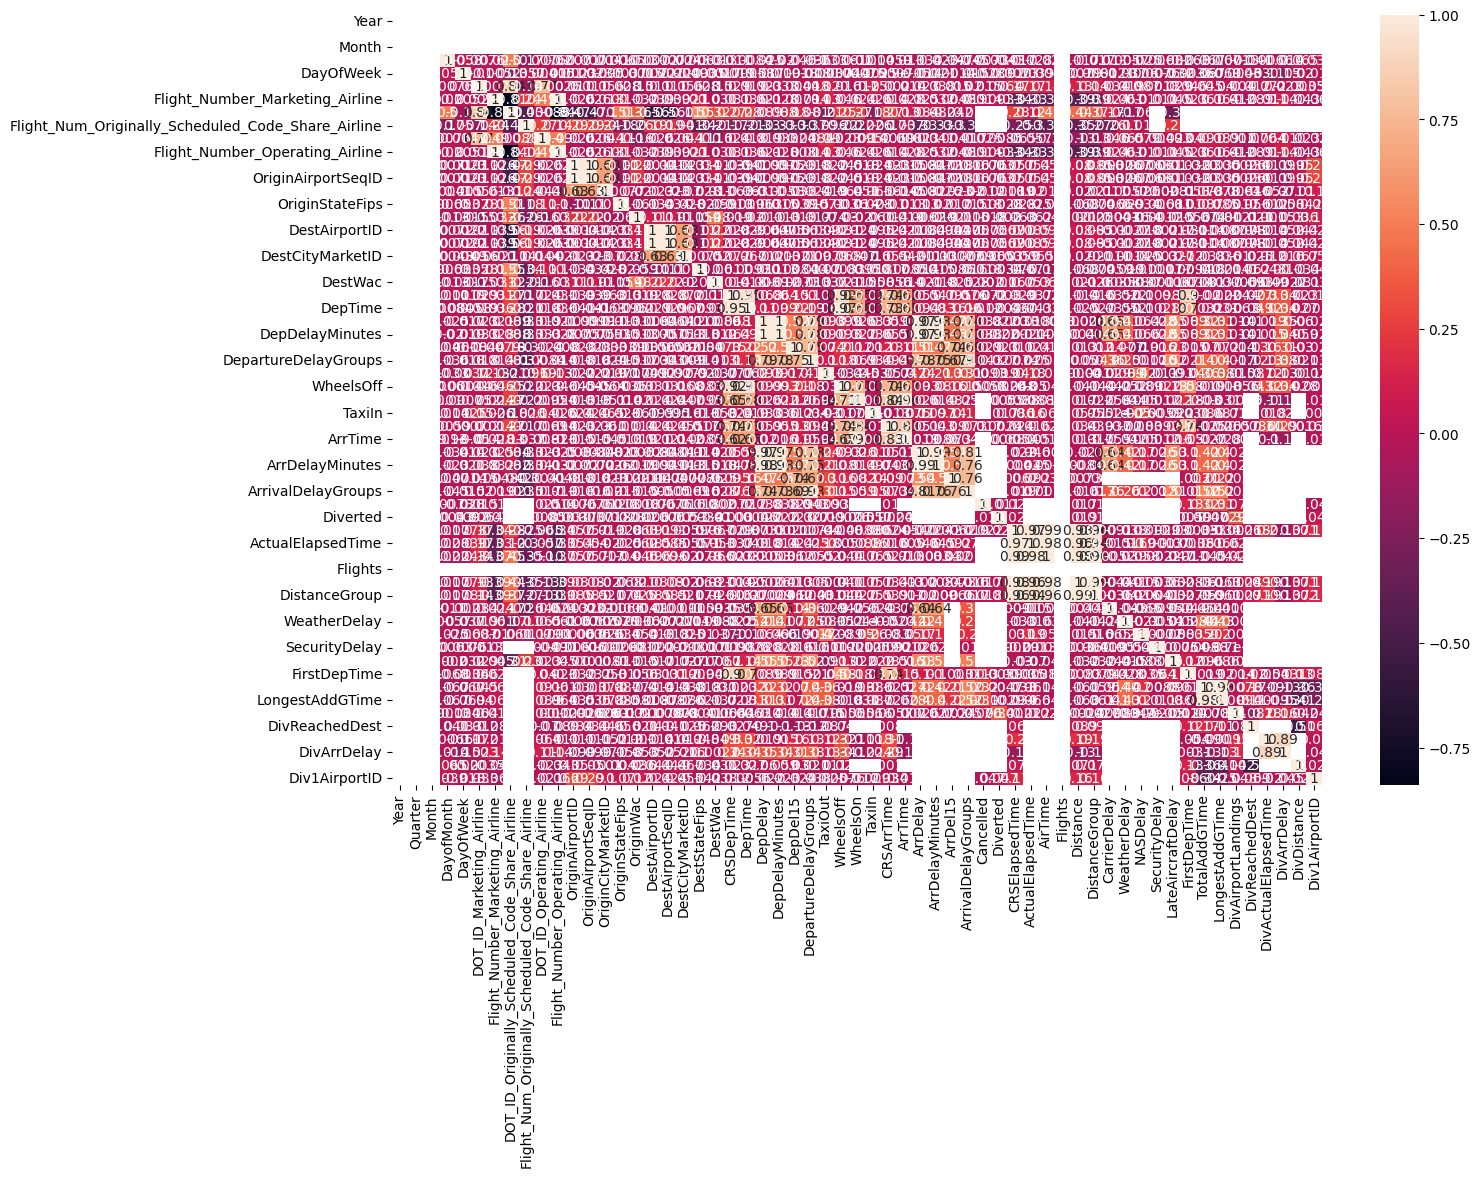

In [6]:
numeric_data = df.select_dtypes(include=['number'])

corr_matrix = numeric_data.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot = True)

In [7]:
df['DayOfWeek'] = pd.to_numeric(df['DayOfWeek'], errors='coerce')

# Group by DayOfWeek and calculate average delay
avg_delay_week = df.groupby('DayOfWeek')['ArrDelayMinutes'].mean().reset_index()

# Plot using Plotly
fig = px.bar(avg_delay_week, x='DayOfWeek', y='ArrDelayMinutes',
             labels={'DayOfWeek': 'Day of the Week', 'ArrDelayMinutes': 'Average Delay'},
             title='Average Delay by Day of the Week')

fig.update_traces(marker_color='skyblue')
fig.show()

In [ ]:
import pandas as pd
import joblib
import requests
import time
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRegressor

# Weather API Key
WEATHER_API_KEY = "cc9bea040e2c4d5a814181216251903"
WEATHER_URL = "http://api.weatherapi.com/v1/current.json"

def get_weather(city):
    """Fetches weather condition for a given city."""
    try:
        response = requests.get(WEATHER_URL, params={"key": WEATHER_API_KEY, "q": city}, timeout=3)
        data = response.json()
        if "current" in data:
            return data["current"]["condition"]["text"]
    except Exception:
        return "Unknown"
    return "Unknown"

# Load dataset
df = pd.read_csv("flight_data_2018_2024.csv")  # Replace with actual dataset path

# Clean city names
df["CleanOriginCity"] = df["OriginCityName"].astype(str).apply(lambda x: x.split(",")[0].split("/")[0].strip())
df["CleanDestCity"] = df["DestCityName"].astype(str).apply(lambda x: x.split(",")[0].split("/")[0].strip())

# Use ThreadPoolExecutor for faster weather data retrieval
with ThreadPoolExecutor(max_workers=10) as executor:
    weather_results_origin = dict(executor.map(lambda city: (city, get_weather(city)), df["CleanOriginCity"].unique()))
    weather_results_dest = dict(executor.map(lambda city: (city, get_weather(city)), df["CleanDestCity"].unique()))

# Assign weather data
df["OriginWeather"] = df["CleanOriginCity"].map(weather_results_origin)
df["DestWeather"] = df["CleanDestCity"].map(weather_results_dest)

# Convert categorical weather data to numeric
df["OriginWeather"] = df["OriginWeather"].astype("category").cat.codes
df["DestWeather"] = df["DestWeather"].astype("category").cat.codes

df.fillna(0, inplace=True)  # Fill NaN values

# Selecting features
feature_cols = ["CRSDepTime", "CRSArrTime", "Distance", "DayOfWeek", "Month", "OriginWeather", "DestWeather"]
X = df[feature_cols]
y = df["Cancelled"]
y_delay = df["ArrDelay"]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
_, _, y_train_delay, y_test_delay = train_test_split(X, y_delay, test_size=0.2, random_state=42)


xgb_model = XGBClassifier(objective="binary:logistic", eval_metric="logloss", learning_rate=0.1,
                          n_estimators=300, max_depth=10, min_child_weight=5, subsample=0.8,
                          colsample_bytree=0.8, use_label_encoder=False)
xgb_model.fit(X_train, y_train)

xgb_delay_model = XGBRegressor(objective="reg:squarederror", n_estimators=100)
xgb_delay_model.fit(X_train, y_train_delay)

# Save Models

joblib.dump(xgb_delay_model, "xgb_delay_model.pkl")
joblib.dump(feature_cols, "feature_columns.pkl")

print("✅ Models trained & saved successfully!")


<ipython-input-2-8f083fb3c24f>:26: DtypeWarning: Columns (11,13,86,93,94,101) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("flight_data_2018_2024.csv")  # Replace with actual dataset path
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:07:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Models trained & saved successfully!


In [ ]:
import pandas as pd
import joblib
import requests
from geopy.distance import great_circle

# **Load OpenFlights Airport Data**
url = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat"
columns = ["Airport ID", "Name", "City", "Country", "IATA", "ICAO", "Latitude", "Longitude", "Altitude", "Timezone", "DST", "Tz database time zone", "Type", "Source"]
airport_data = pd.read_csv(url, names=columns, index_col=False)

# Convert IATA codes to uppercase for consistency
airport_data["IATA"] = airport_data["IATA"].astype(str).str.upper()

# **Function to Get Airport Coordinates**
def get_airport_coordinates(iata_code):
    """Fetch latitude & longitude of an airport using its IATA code."""
    result = airport_data[airport_data["IATA"] == iata_code.upper()]

    if not result.empty:
        lat, lon = float(result.iloc[0]["Latitude"]), float(result.iloc[0]["Longitude"])
        print(f"✅ {iata_code}: ({lat}, {lon}) [Dataset]")
        return lat, lon

    print(f"🚨 Airport code {iata_code} not found!")
    return None

# **Function to Calculate Airline Distance**
def calculate_airline_distance(iata1, iata2):
    """Calculate the great-circle distance between two airports given their IATA codes."""
    coords1 = get_airport_coordinates(iata1)
    coords2 = get_airport_coordinates(iata2)

    if not coords1 or not coords2:
        return None  # Error in fetching coordinates

    distance_km = great_circle(coords1, coords2).kilometers
    distance_miles = distance_km * 0.621371  # Convert to miles
    print(f"📏 Great-Circle Distance: {distance_km:.2f} km ({distance_miles:.2f} miles)")
    return distance_miles

# **Function to Get Weather Conditions**
def get_weather(city):
    """Fetch real-time weather condition of a city using WeatherAPI."""
    WEATHER_API_KEY = "cc9bea040e2c4d5a814181216251903"
    WEATHER_URL = "http://api.weatherapi.com/v1/current.json"

    try:
        response = requests.get(WEATHER_URL, params={"key": WEATHER_API_KEY, "q": city}, timeout=3)
        data = response.json()
        if "current" in data:
            return data["current"]["condition"]["text"]
    except Exception:
        return "Unknown"
    return "Unknown"

# **Load Trained Models**

xgb_delay_model = joblib.load("xgb_delay_model.pkl")
feature_cols = joblib.load("feature_columns.pkl")

# **User Inputs**
origin_code = input("Enter Origin Airport Code: ").strip().upper()
dest_code = input("Enter Destination Airport Code: ").strip().upper()
dep_time = int(input("Enter Departure Time (HHMM format): "))
arr_time = int(input("Enter Arrival Time (HHMM format): "))
day_of_week = int(input("Enter Day of Week (1=Monday, 7=Sunday): "))
month = int(input("Enter Month (1-12): "))

# **Calculate Distance**
distance = calculate_airline_distance(origin_code, dest_code)

if distance is None:
    print("🚨 Error: Could not calculate distance. Exiting.")
    exit()

# **Get Weather Conditions**
origin_weather = get_weather(origin_code)
dest_weather = get_weather(dest_code)

# **Convert Weather Conditions to Categorical Codes**
weather_categories = {'Clear': 0, 'Partly Cloudy': 1, 'Cloudy': 2, 'Rain': 3, 'Thunderstorm': 4, 'Snow': 5, 'Unknown': -1}
origin_weather_code = weather_categories.get(origin_weather, -1)
dest_weather_code = weather_categories.get(dest_weather, -1)

# **Prepare Input Data**
input_data = pd.DataFrame([[dep_time, arr_time, distance, day_of_week, month, origin_weather_code, dest_weather_code]], columns=feature_cols)

# **Make Predictions**

delay_pred_xgb = xgb_delay_model.predict(input_data)[0]

# **Display Results**
print("\n--- Flight Prediction Results ---")
print(f"📏 Distance To Travel: {distance:.2f} miles")
print(f"🌦 Origin Weather: {origin_weather}")
print(f"🌦 Destination Weather: {dest_weather}")
if delay_pred_xgb<0:
  print("The Flight is likely to be in Time")
print(f"The Flight is likely to be Delayed \n⏳ Estimated Arrival Delay: {delay_pred_xgb} minutes")


Enter Origin Airport Code: hyd
Enter Destination Airport Code: del
Enter Departure Time (HHMM format): 1100
Enter Arrival Time (HHMM format): 1300
Enter Day of Week (1=Monday, 7=Sunday): 2
Enter Month (1-12): 2
✅ HYD: (17.2313175201, 78.4298553467) [Dataset]
✅ DEL: (28.5665, 77.103104) [Dataset]
📏 Great-Circle Distance: 1267.69 km (787.70 miles)

--- Flight Prediction Results ---
📏 Distance To Travel: 787.70 miles
🌦 Origin Weather: Clear
🌦 Destination Weather: Clear
The Flight is likely to be Delayed 
⏳ Estimated Arrival Delay: 5.899325847625732 minutes
